In [1]:
# import dependencies

import pandas as pd
from config import api_key
import requests
import os
import math
from datetime import datetime
from config import finn
import finnhub
finnhub_client = finnhub.Client(api_key=finn)
import time
import datetime
now = datetime.datetime.now()
import yfinance as yf
import numpy as np
from scipy.stats import norm
from datetime import date

In [4]:
# url for api key
option_url = 'https://api.tdameritrade.com/v1/marketdata/chains'

In [97]:

# input conditions for options
symbol = input("Ticker")
strikecount = input("Strikecount")
expMonth = input('Exp Month')
contract = input('Contract type PUT, CALL, ALL')
strike = input("Strike Price")

TickerGOOG
Strikecount12
Exp MonthALL
Contract type PUT, CALL, ALLALL
Strike Price


In [9]:
#uses api key to extract data
params = {'apikey':api_key,
         'symbol':symbol,
         'contractType': contract,
          'strikeCount': strikecount,
          'includeQuotes': False,
          'stratgey': 'SINGLE',
          'expMonth': expMonth,
          'optionType': 'S'


         }

content = requests.get(url = option_url, params=params)

data = content.json()

In [10]:
data['putExpDateMap']['2023-04-06:29']

{'89.0': [{'putCall': 'PUT',
   'symbol': 'GOOG_040623P89',
   'description': 'GOOG Apr 6 2023 89 Put (Weekly)',
   'exchangeName': 'OPR',
   'bid': 1.1,
   'ask': 1.16,
   'last': 1.1,
   'mark': 1.13,
   'bidSize': 130,
   'askSize': 28,
   'bidAskSize': '130X28',
   'lastSize': 0,
   'highPrice': 1.12,
   'lowPrice': 0.92,
   'openPrice': 0.0,
   'closePrice': 1.31,
   'totalVolume': 8,
   'tradeDate': None,
   'tradeTimeInLong': 1678308780104,
   'quoteTimeInLong': 1678309199895,
   'netChange': -0.21,
   'volatility': 31.716,
   'delta': -0.22,
   'gamma': 0.035,
   'theta': -0.04,
   'vega': 0.08,
   'rho': -0.017,
   'openInterest': 268,
   'timeValue': 1.1,
   'theoreticalOptionValue': 1.13,
   'theoreticalVolatility': 29.0,
   'optionDeliverablesList': None,
   'strikePrice': 89.0,
   'expirationDate': 1680811200000,
   'daysToExpiration': 29,
   'expirationType': 'S',
   'lastTradingDay': 1680825600000,
   'multiplier': 100.0,
   'settlementType': ' ',
   'deliverableNote': '

In [104]:
common_list = ["GOOG"]

In [105]:
vol = pd.read_csv('Sigma.csv')

In [106]:
# Current Price

arb = {}



for symbol in common_list:
    
    sigma  = vol.loc[vol["Unnamed: 0"] == f"{symbol}"]["0"].tolist()[0]

    # Set the start and end date
    start_date = '2023-01-01'

    t = date.today()

    t = str(t)

    # Get the data
    test = int(time.time())
    info = finnhub_client.stock_candles(symbol, 'D', test, test)

    test = int(time.time())
    info = finnhub_client.stock_candles(symbol, 'D', test, test)

    if info["s"] == 'no_data':
        time.sleep(3)

        print(True)

        info = finnhub_client.stock_candles(symbol, 'D', test, test)
        
        continue

    data  = pd.DataFrame(info, index= [0])
    data.columns = ["Close", "High", "Low", "Open", "S", "Timestamp", "Volume"]
    data["Datetime"] = datetime.datetime.fromtimestamp(data["Timestamp"])
    data = data.drop(columns=["S", "Timestamp"])
    data = data.set_index("Datetime")

    close = data['Close'].values[0]


    #uses api key to extract data
    params = {'apikey':api_key,
             'symbol':symbol,
             'contractType': contract,
              'strikeCount': strikecount,
              'includeQuotes': False,
              'stratgey': 'SINGLE',
              'expMonth': expMonth,
              'optionType': 'S'


             }

    content = requests.get(url = option_url, params=params)

    data = content.json()




    dates_ref = []

    int_year = now.year
    int_month = now.month
    int_day = now.day

    for i in data['putExpDateMap']:
        dates_ref.append(i)

    for i in dates_ref:

        #create outline for 
        df = {}
        date_now = i[:10]
        volume = []
        theta = []
        gamma = []
        delta = []
        interest = []

        #iterate through each strike
        for strike in data["putExpDateMap"][i]:
            df[strike] = {'Put': '', 'Call':''}
            ask = data["putExpDateMap"][i][strike][0]["ask"]
            
            bid = data["putExpDateMap"][i][strike][0]["bid"]
            
            
            df[strike]['Put'] = (ask + bid) / 2
            df[strike]['Put - Volume'] = data["putExpDateMap"][i][strike][0]["totalVolume"]

        for strike in data["callExpDateMap"][i]:
            
            ask = data["callExpDateMap"][i][strike][0]["ask"]
            
            bid = data["callExpDateMap"][i][strike][0]["bid"]

            df[strike]['Call'] = (ask + bid) / 2
            df[strike]['Call - Volume'] = data["callExpDateMap"][i][strike][0]["totalVolume"]



        label = i

        strike_date = i.split('-')

        year = int(strike_date[0])

        month = int(strike_date[1])

        day = int(strike_date[2].split(':')[0])
        
        count = int(strike_date[2].split(':')[1]) / 365

        #convert to dataframe
        option_df = pd.DataFrame.from_dict(df, orient='index')

        for row, i in option_df.iterrows():


            K = float(row)

            C = i['Call']

            P = i['Put']

            t = 'p'
            
            # obtain true put value using black scholes formula

            true_put = blackScholes(r, close, K, count, sigma, t)

            t = 'c'
            
            # obtain true call value using black scholes formula

            true_call = blackScholes(r, close, K, count, sigma, t)

            diff_put = true_put - P

            diff_call = true_call - C
            
            ### assigning initial volatility estimate for input in Newton_rap procedure
            sigma = 0.3
            
            sigma_put = sigma - diff_put / vega(close, K, count, r, sigma)
            
            sigma_call = sigma - diff_call / vega(close, K, count, r, sigma)

            arb[f'{label} - {K}'] = {'Date': label, 'Strike': K, 'Put': df[row]['Put'], 'True Put' : true_put, 'Call': df[row]['Call'], 'True Call': true_call, 'Symbol': symbol, 'Call - Volume': df[row]['Call - Volume'], 'Put - Volume': df[row]['Put - Volume'], 'Price': close, "IV_Put": sigma_put, "IV_Call": sigma_call}

options_df = pd.DataFrame.from_dict(arb, orient='index')


/var/folders/g3/164q6cz52jv0sjllnsg7jdsm0000gn/T/ipykernel_90290/3408162160.py:36: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data["Datetime"] = datetime.datetime.fromtimestamp(data["Timestamp"])


In [107]:
options_df = pd.DataFrame.from_dict(arb, orient='index')
options_df

,Date,Strike,Put,True Put,Call,True Call,Symbol,Call - Volume,Put - Volume,Price,IV_Put,IV_Call
2023-03-10:2 - 89.0,2023-03-10:2,89.0,0.025,0.002036,5.775,5.661789,GOOG,1,107,94.65,0.308217,0.340508
2023-03-10:2 - 90.0,2023-03-10:2,90.0,0.045,0.008109,4.775,4.667972,GOOG,418,544,94.65,0.313199,0.338294
2023-03-10:2 - 91.0,2023-03-10:2,91.0,0.090,0.031256,3.825,3.691228,GOOG,55,1123,94.65,0.321018,0.347862
2023-03-10:2 - 92.0,2023-03-10:2,92.0,0.185,0.097656,2.895,2.757737,GOOG,367,1568,94.65,0.331250,0.349109
2023-03-10:2 - 93.0,2023-03-10:2,93.0,0.360,0.251815,2.085,1.912006,GOOG,650,2238,94.65,0.338706,0.361892
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19:1017 - 100.0,2025-12-19:1017,100.0,17.750,18.671154,23.500,18.741331,GOOG,1,0,94.65,0.281305,0.396579
2025-12-19:1017 - 105.0,2025-12-19:1017,105.0,19.750,21.589455,21.375,16.930642,GOOG,0,0,94.65,0.267985,0.377352
2025-12-19:1017 - 110.0,2025-12-19:1017,110.0,22.750,24.676732,19.350,15.288928,GOOG,1,0,94.65,0.268979,0.365385
2025-12-19:1017 - 115.0,2025-12-19:1017,115.0,25.750,27.919546,17.250,13.802750,GOOG,0,0,94.65,0.265480,0.354850


In [108]:
options_df.loc[options_df["Date"] == "2023-04-06:29"]

,Date,Strike,Put,True Put,Call,True Call,Symbol,Call - Volume,Put - Volume,Price,IV_Put,IV_Call
2023-04-06:29 - 89.0,2023-04-06:29,89.0,1.130,1.022567,6.650,6.813879,GOOG,1,8,94.65,0.310114,0.284573
2023-04-06:29 - 90.0,2023-04-06:29,90.0,1.285,1.283978,5.950,6.076878,GOOG,3,16,94.65,0.300096,0.288063
2023-04-06:29 - 91.0,2023-04-06:29,91.0,1.620,1.589770,5.600,5.384258,GOOG,8,41,94.65,0.302843,0.320288
2023-04-06:29 - 92.0,2023-04-06:29,92.0,1.880,1.942456,4.050,4.738532,GOOG,1,62,94.65,0.294129,0.235277
2023-04-06:29 - 93.0,2023-04-06:29,93.0,2.310,2.343838,4.350,4.141502,GOOG,8,20,94.65,0.296820,0.319594
2023-04-06:29 - 94.0,2023-04-06:29,94.0,2.620,2.794947,3.750,3.594198,GOOG,15,40,94.65,0.283562,0.314639
2023-04-06:29 - 95.0,2023-04-06:29,95.0,3.175,3.296015,3.225,3.096854,GOOG,37,26,94.65,0.288630,0.312040
2023-04-06:29 - 96.0,2023-04-06:29,96.0,3.700,3.846492,2.725,2.648919,GOOG,69,13,94.65,0.286236,0.307148
2023-04-06:29 - 97.0,2023-04-06:29,97.0,3.700,4.445093,2.285,2.249108,GOOG,98,2,94.65,0.229984,0.303373
2023-04-06:29 - 98.0,2023-04-06:29,98.0,4.125,5.089879,1.900,1.895481,GOOG,11,15,94.65,0.209310,0.300425


In [82]:
from matplotlib import pyplot as plt

In [100]:
options_df.loc[options_df["Strike"] == 155.0]

,Date,Strike,Put,True Put,Call,True Call,Symbol,Call - Volume,Put - Volume,Price,IV_Put,IV_Call
2023-03-10:2 - 155.0,2023-03-10:2,155.0,2.695,2.672703,0.635,0.559689,AAPL,59677,7547,152.87,0.304939,0.316682
2023-03-17:9 - 155.0,2023-03-17:9,155.0,3.675,4.034004,1.725,1.980423,AAPL,12571,4375,152.87,0.262511,0.273328
2023-03-24:16 - 155.0,2023-03-24:16,155.0,4.450,4.933787,2.660,2.939618,AAPL,2945,442,152.87,0.262110,0.278101
2023-03-31:23 - 155.0,2023-03-31:23,155.0,4.850,5.652352,3.200,3.717572,AAPL,989,279,152.87,0.247588,0.266191
2023-04-06:29 - 155.0,2023-04-06:29,155.0,5.200,6.183571,3.650,4.299677,AAPL,141,197,152.87,0.242782,0.262206
2023-04-14:37 - 155.0,2023-04-14:37,155.0,5.700,6.810254,4.300,4.994182,AAPL,1149,129,152.87,0.242819,0.264248
2023-04-21:44 - 155.0,2023-04-21:44,155.0,6.050,7.302675,4.800,5.545924,AAPL,4657,2740,152.87,0.240839,0.264772
2023-05-19:72 - 155.0,2023-05-19:72,155.0,8.000,8.942583,7.150,7.422886,AAPL,1499,491,152.87,0.265201,0.289925
2023-06-16:100 - 155.0,2023-06-16:100,155.0,9.025,10.261904,8.725,8.978896,AAPL,512,992,152.87,0.261251,0.292046
2023-07-21:135 - 155.0,2023-07-21:135,155.0,9.975,11.648129,10.350,10.660474,AAPL,491,234,152.87,0.254880,0.291627


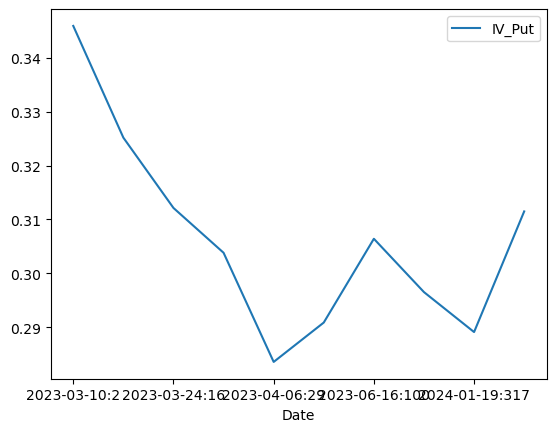

In [109]:
options_df.loc[options_df["Strike"] == 94.0].plot(x="Date", y="IV_Put")

plt.savefig('GOOG_94_Expirations_Put.png', dpi=300)

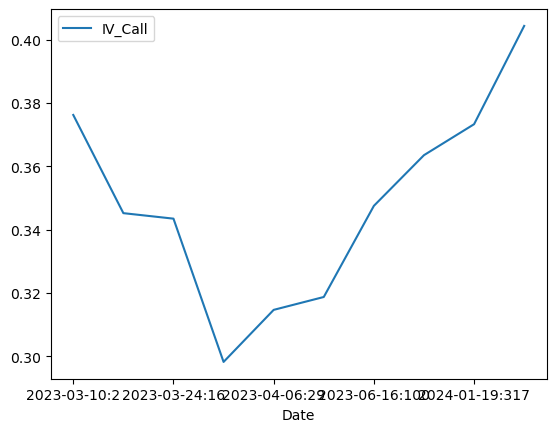

In [111]:
options_df.loc[options_df["Strike"] == 94.0].plot(x="Date", y="IV_Call")

plt.savefig('GOOG_94_Expirations_Call.png', dpi=300)

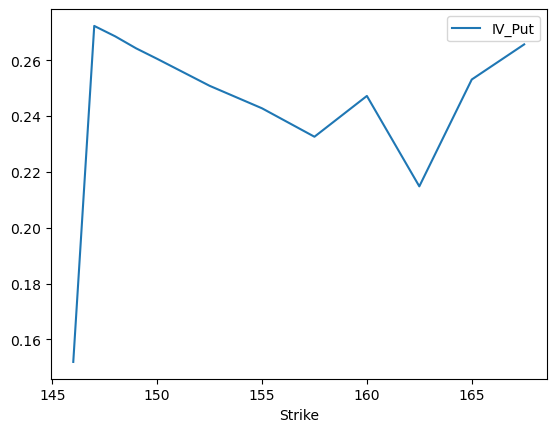

In [84]:
options_df.loc[options_df["Date"] == "2023-04-06:29"].plot(x="Strike", y="IV_Put")

plt.savefig('figure_1.png', dpi=300)

<AxesSubplot:xlabel='Strike'>

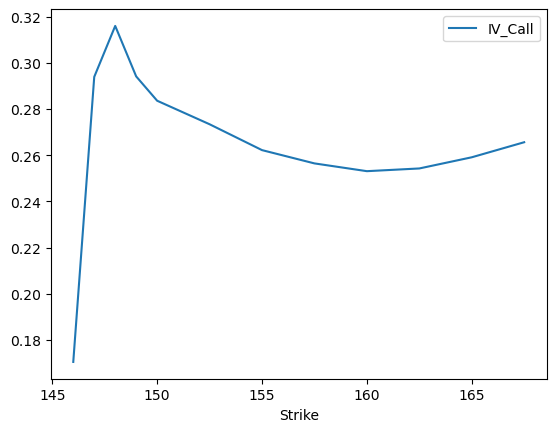

In [80]:
options_df.loc[options_df["Date"] == "2023-04-06:29"].plot(x="Strike", y="IV_Call")

In [15]:
def blackScholes(r, S, K, T, sigma, t):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == "c":
        price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    elif t == "p":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
    return price


In [68]:
r = 0.02

In [31]:
 

N_prime = norm.pdf


def vega(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''

    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)

    
    vega = S  * np.sqrt(T) * N_prime(d1)
    return vega